In [2]:
%matplotlib inline
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.patches
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt

from matplotlib import colors
from scipy import stats
import sys
import os
import os.path
import cv2

# Helper function used for visualization in the following examples


def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : Dict[str, Axes]
        Mapping between the title / label and the Axes.

    fontsize : int, optional
        How big the label should be
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

In [32]:
%config IPCompleter.greedy=True

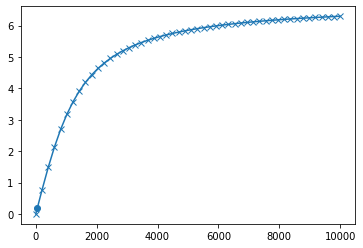

In [7]:
def px_to_q(file, distance_pixels_from_center):
    '''
    Calculate q in reverese Ångström

    Parameters
    ----------
    file : path to hdf5 file to read distances from
    distance_pixels_from_center : distance in pixels from center

    Returns
    q : momentum transfer in reverese Å
    '''

    distances = np.atleast_1d(np.asarray(distance_pixels_from_center))
    q = np.zeros(np.shape(distances))

    wavelength_AA = f['LCLS']['wavelengthInAngstromMean'][()
                                                          ]  # wavelength in Å
    # Distance in m
    distance_to_detector_m = f['LCLS']['detectorDistanceInMeterMean'][()]
    pixel_size_m = f['LCLS']['detectorPixelSizeInMicron'][()] * \
        1e-6  # pixel size in m

    # 2d to q
    # q=2*pi/d or d= (2*pi)/q , 2 d = 4 pi / q

    # BRAGGS LAW:
    # 2*d sin(theta) = lambda
    # OR written as:
    # 4 pi sin(theta)/q = lambda
    # q = 4 pi sin(theta)/lambda

    # reflection angle noted with alpha
    # Also considering that theta = alpha /2 :
    # q = 4 pi sin(alpha/2)/lambda

    # distance from center = x
    # distance to detector = y
    # Also considering that tan(alpha) = x/y:
    # alpha= arctan(x/y)
    # q = 4 pi sin(arctan(x/y)/2)/lambda

    for distance_index, distance in enumerate(distances):
        distance_m = distance*pixel_size_m

        # fraction of distance from center and distance to the detector
        fraction = np.divide(distance_m, distance_to_detector_m)

        # the scattering angle, note that it's half the angle from the
        # reflection to the beam at the interaction point
        scattering_angle_theta = np.arctan(fraction)/2.0

        #
        # in reverse Angstrom
        q[distance_index] = 4*np.pi * \
            np.divide(np.sin(scattering_angle_theta), wavelength_AA)

    return(q)


pxs = np.linspace(0, 10000)
q = px_to_q(f, pxs)
plt.plot(pxs, q, marker='x')
plt.scatter([50], [px_to_q(f, 50)])

(array([2., 2., 1., 0., 0., 0., 3., 1., 3., 1., 2., 2., 6., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1., 4., 0., 1., 1., 2., 2.,
        3., 0., 2., 0., 0., 1., 1., 3., 3., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 4., 1., 0., 2., 0., 3., 2., 0., 1., 0., 1., 1., 2., 1., 0.,
        2., 2., 0., 1., 0., 1., 0., 0., 1., 2., 0., 1., 1., 0., 0., 0., 1.,
        0., 2., 1., 1., 1., 1., 2., 1., 0., 0., 1., 2., 0., 1., 1.]),
 array([-3.04840539, -2.98668306, -2.92496072, -2.86323839, -2.80151606,
        -2.73979372, -2.67807139, -2.61634905, -2.55462672, -2.49290438,
        -2.43118205, -2.36945972, -2.30773738, -2.24601505, -2.18429271,
        -2.12257038, -2.06084805, -1.99912571, -1.93740338, -1.87568104,
        -1.81395871, -1.75223637, -1.69051404, -1.62879171, -1.56706937,
        -1.50534704, -1.4436247 , -1.38190237, -1.32018004, -1.2584577 ,
        -1.19673537, -1.13501303, -1.0732907 , -1.01156836, -0.94984603,
        -0.8881237 , -0.82640136, -0.76

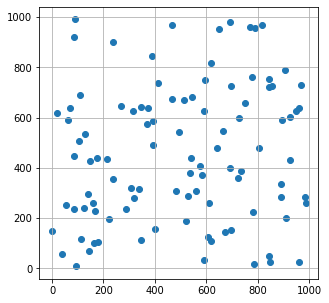

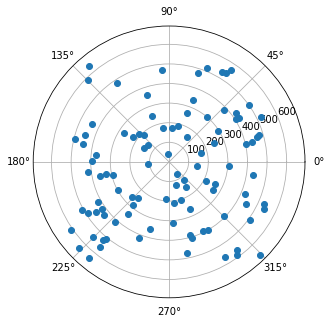

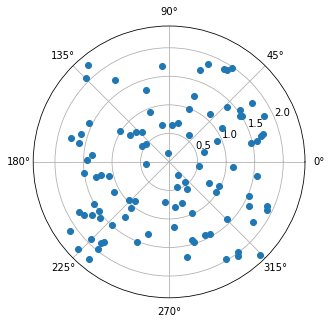

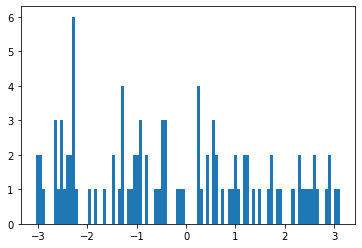

In [54]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta


def pol2cart(r, theta):
    x = np.multiply(r,np.cos(theta))
    y = np.multiply(r,np.sin(theta))
    return x, y 

def convert_coordinates(x, y, center=None):
    '''
    x is detector coordinate x
    y is detector coordinate y
    
    center is where the bem goes 
    through the detector in format (x,y)
    
    returns:
    
    r:      distance from center in pixels
    theta:  angle in the detector plane of x,y, measured counter-
            clockwise. 0 is at x larger than center[0], 
            and y == center[1]
    '''
    if center==None:
        error=True 
        #ADD SOME ERROR OR WARNING HERE LATER
    else:
        x_offset=np.subtract(x,center[0])
        y_offset=np.subtract(y,center[1])
        r,theta=cart2pol(x_offset,y_offset)
    return r,theta
    
def pos2q(r,wavelength_AA,distance_to_detector_m,pixel_size_m):
    '''
    r: distance in pixels from center, scalar or array
    wavelength_AA: wavelength in Angstrom
    distance_to_detector_m: distance to the center in meters
    pixel_size_m: size of a pixel in m
    '''
    
    r_array = np.atleast_1d(np.asarray(r))
    q = np.zeros(np.shape(r_array))   
    
    # 2d to q
    # q=2*pi/d or d= (2*pi)/q , 2 d = 4 pi / q

    # BRAGGS LAW:
    # 2*d sin(theta) = lambda
    # OR written as:
    # 4 pi sin(theta)/q = lambda
    # q = 4 pi sin(theta)/lambda

    # reflection angle noted with alpha
    # Also considering that theta = alpha /2 :
    # q = 4 pi sin(alpha/2)/lambda

    # distance from center = x
    # distance to detector = y
    # Also considering that tan(alpha) = x/y:
    # alpha= arctan(x/y)
    # q = 4 pi sin(arctan(x/y)/2)/lambda

    for r_index, r in enumerate(r_array):
        r_m = r*pixel_size_m

        # fraction of distance from center and distance to the detector
        fraction = np.divide(r_m, distance_to_detector_m)

        # the scattering angle, note that it's half the angle from the
        # reflection to the beam at the interaction point
        scattering_angle = np.arctan(fraction)/2.0

        #
        # in reverse Angstrom
        q[r_index] = 4*np.pi * \
            np.divide(np.sin(scattering_angle), wavelength_AA)

    return(q)
    


point_count = 100


test_data = np.random.randint(0, high=1000, size=(2, point_count))



plt.figure(figsize=(5, 5))
plt.scatter(test_data[0], test_data[1])
plt.grid()


#put it in center, convert to r,theta
center=(500,500)
r, theta = convert_coordinates(test_data[0], test_data[1],center=center)

plt.figure(figsize=[5, 5])

plt.polar(theta, r, 'o')



plt.figure(figsize=[5,5])
wavelength_AA = f['LCLS']['wavelengthInAngstromMean'][()                                                      ]  # wavelength in Å
# Distance in m
distance_to_detector_m = f['LCLS']['detectorDistanceInMeterMean'][()]
pixel_size_m = f['LCLS']['detectorPixelSizeInMicron'][()] * \
    1e-6  # pixel size in m

q=pos2q(r,wavelength_AA,distance_to_detector_m,pixel_size_m)
plt.polar(theta, q, 'o')


plt.figure()
plt.hist(theta,bins=100)


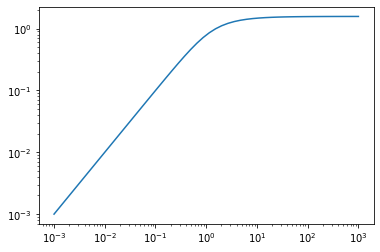

In [4]:
pxs = np.logspace(-3, 3)
plt.loglog(pxs, np.arctan(pxs))

(0.0, 2.4)

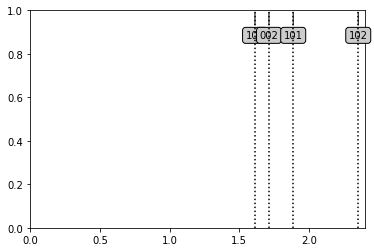

In [5]:
plt.figure()
ax = plt.gca()

ax.set_xlim([0.5, 2.4])


def add_hkl_to_ax(ax, add_labels=False, only_plot_within_boundries=True):

    #Dowell & Rinfrett, Nature, 1960
    list_of_hkl_names = ["100", "002", "101", "102",
                         "110", "103", "200", "112", "201", "202"]
    list_of_hkl_d = [3.897, 3.669, 3.331, 2.671,
                     2.249, 2.072, 1.948, 1.918, 1.883, 1.721]
    list_of_hkl_q = np.divide(2*np.pi, list_of_hkl_d)

    bbox_args = dict(boxstyle="round", fc="0.8")
    arrow_args = dict(arrowstyle="-")

    xlims = ax.get_xlim()

    for hkl_index, hkl_q in enumerate(list_of_hkl_q):
        if hkl_q > xlims[0] and hkl_q < xlims[1]:
            ax.axvline(x=hkl_q, ls=':', c='black', zorder=10)
            if add_labels:
                ax.annotate(list_of_hkl_names[hkl_index],
                            xy=(hkl_q, 1), xycoords=("data", 'axes fraction'),
                            xytext=(0, -20), textcoords='offset points',
                            ha="center", va="top",
                            bbox=bbox_args,
                            arrowprops=arrow_args)


add_hkl_to_ax(ax, add_labels=True)
ax.set_xlim(left=0)

['LCLS', 'shots']


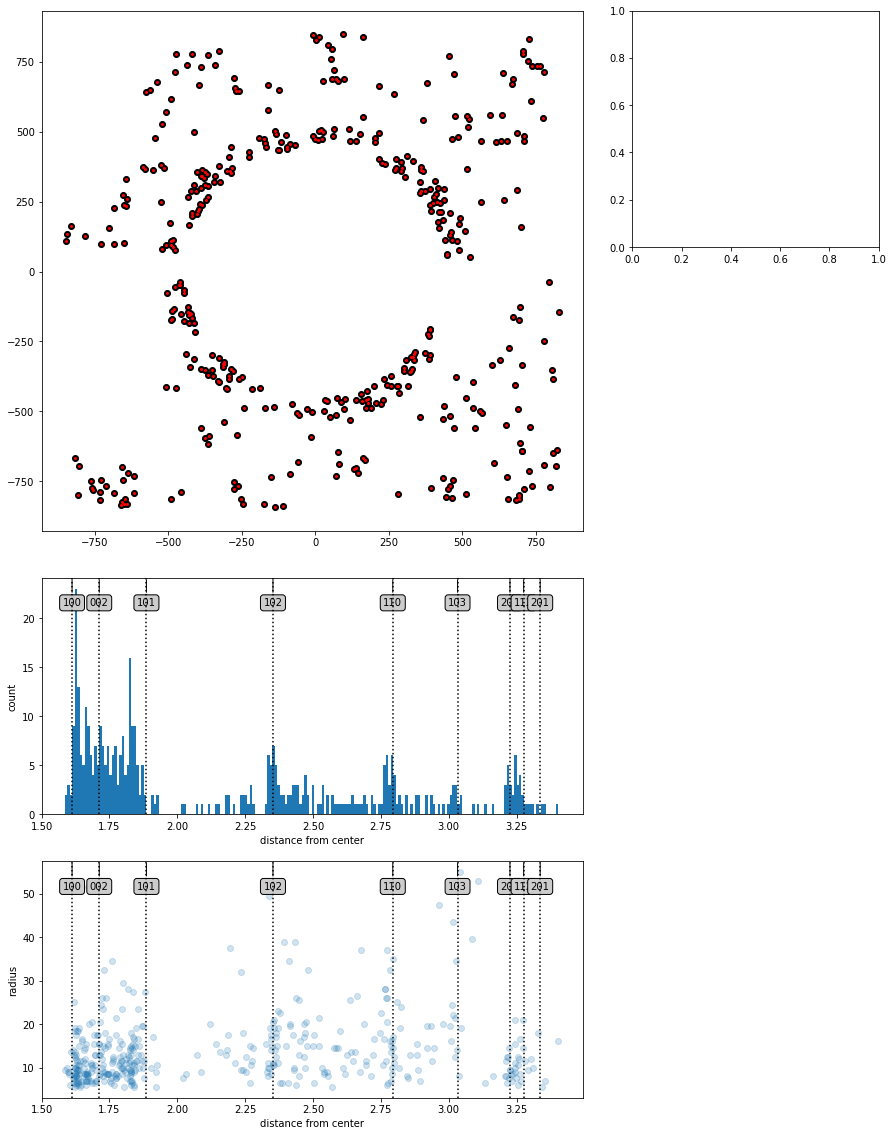

In [81]:
# Data from Jonas 20 Oct
f = h5py.File('/Users/olofjonsson/Downloads/r0144_type1-peaks.h5', 'r')
print(list(f.keys()))

list_of_shots = [x for x in f['shots'].keys()]

plt.close('all')
axd = plt.figure(figsize=[15, 20]).subplot_mosaic([["hits", "hits", "colorbar"], [
    "hits", "hits", "."], ["distance", "distance", "."], ["radius", "radius", "."]])


# identify_axes(axd)

ax = axd["hits"]

distance_to_center_ax = axd["distance"]


x_size = 1760
y_size = 1760
center_of_detector_pixels = [np.divide(x_size, 2), np.divide(y_size, 2)]

distances_to_center_pixels = []
radii = []



for shot_index, shot in enumerate(list_of_shots):

    if f['shots'][shot]['numberOfPeaks'][()] > 0:

        peaks = [[x-center_of_detector_pixels[0], y-center_of_detector_pixels[1]]
                 for x, y in f['shots'][shot]['peakCenterOfMassInPixels']]
        radii_this_shot = f['shots'][shot]['peakRadiiInPixels']
        for peak_index, peak in enumerate(peaks):

            peaks = ax.scatter(peak[0], peak[1], c='black')

            distance_to_center = np.sqrt(peak[0]**2+peak[1]**2)
            distances_to_center_pixels.append(distance_to_center)
            radii.append(radii_this_shot[peak_index])
            
            
for shot_index, shot in enumerate(list_of_shots):

    if f['shots'][shot]['numberOfPeaks'][()] > 0:

        peaks = [[convert_coordinates(x,y,center_of_detector_pixels)[0],
                  convert_coordinates(x,y,center_of_detector_pixels)[1]] 
                 for x, y in f['shots'][shot]['peakCenterOfMassInPixels']]
        radii_this_shot = f['shots'][shot]['peakRadiiInPixels']
        
        cartesian=np.array([pol2cart(r,theta) for (r,theta) in peaks])
        ax.scatter(cartesian[:,0], cartesian[:,1],s=4, c='red')
        
        #ax.scatter(x,y,c='red')
        '''
        for peak_index, peak in enumerate(peaks):

            peaks = ax.scatter(peak[0], peak[1], c='black')

            distance_to_center = np.sqrt(peak[0]**2+peak[1]**2)
            distances_to_center_pixels.append(distance_to_center)
            radii.append(radii_this_shot[peak_index])
        '''


distances_to_center = distances_to_center_pixels
_ = distance_to_center_ax.hist(px_to_q(f, distances_to_center), bins=200)

distance_to_center_ax.set_xlabel("distance from center")
distance_to_center_ax.set_ylabel("count")
distance_to_center_ax.set_xlim(left=1.5)
add_hkl_to_ax(distance_to_center_ax, add_labels=True)


wavelength_AA = f['LCLS']['wavelengthInAngstromMean'][()]  # wavelength in Å
# Distance in m
distance_to_detector_m = f['LCLS']['detectorDistanceInMeterMean'][()]
pixel_size_m = f['LCLS']['detectorPixelSizeInMicron'][()] * \
    1e-6  # pixel size in m

q=pos2q(r,wavelength_AA,distance_to_detector_m,pixel_size_m)

axd["radius"].scatter(px_to_q(f, distances_to_center), radii, alpha=0.2)
axd["radius"].set_xlabel("distance from center")
axd["radius"].set_ylabel("radius")
axd["radius"].set_xlim(left=1.5)
add_hkl_to_ax(axd["radius"], add_labels=True)



# f.close()

# list_of_shots[0].value()

# center_of_mass=f['shots']['LCLS_2011_Feb28_r0144_162942_d41_cspad-angavg.h5']['peakCenterOfMassInPixels']
# peakRadiiInPixels=f['shots']['LCLS_2011_Feb28_r0144_162942_d41_cspad-angavg.h5']['peakCenterOfMassInPixels']


# plt.scatter(center_of_mass[:,0],center_of_mass[:,1],s=peakRadiiInPixels[:,1])

In [80]:
np.array(cartesian)[:,0]

array([ 465.20421627,  698.34773379, -285.78492713,  734.64478616])

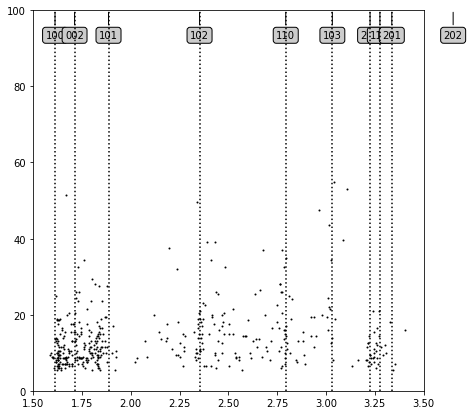

<Figure size 432x288 with 0 Axes>

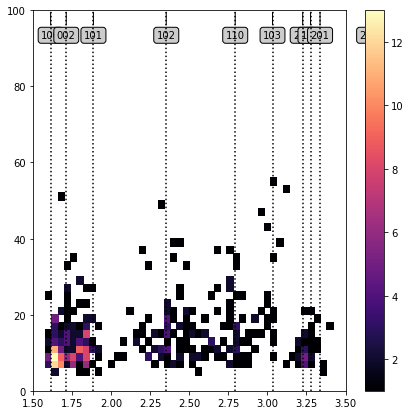

In [10]:
hist_range = [[1.5, 3.5], [0, 100]]  # [[xmin,xmax], [ymin, ymax]]
[[xmin, xmax], [ymin, ymax]] = hist_range

plt.figure(figsize=[7, 7])
plt.scatter(px_to_q(f, distances_to_center), radii, s=1, c='black')
add_hkl_to_ax(plt.gca(), add_labels=True)
plt.xlim(hist_range[0])
plt.ylim(hist_range[1])


plt.figure()


plt.figure(figsize=[7, 7])
counts, xbins, ybins, image = plt.hist2d(px_to_q(
    f, distances_to_center), radii, range=hist_range, cmin=1, bins=[50, 50], cmap='magma')
plt.colorbar()
# plt.contour(counts.T,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],colors='black')
# plt.colorbar()
add_hkl_to_ax(plt.gca(), add_labels=True)

In [11]:


plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0144_type1-peaks.h5
/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0145_type1-peaks.h5
/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0171_type1-peaks.h5
/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0173_type1-peaks.h5


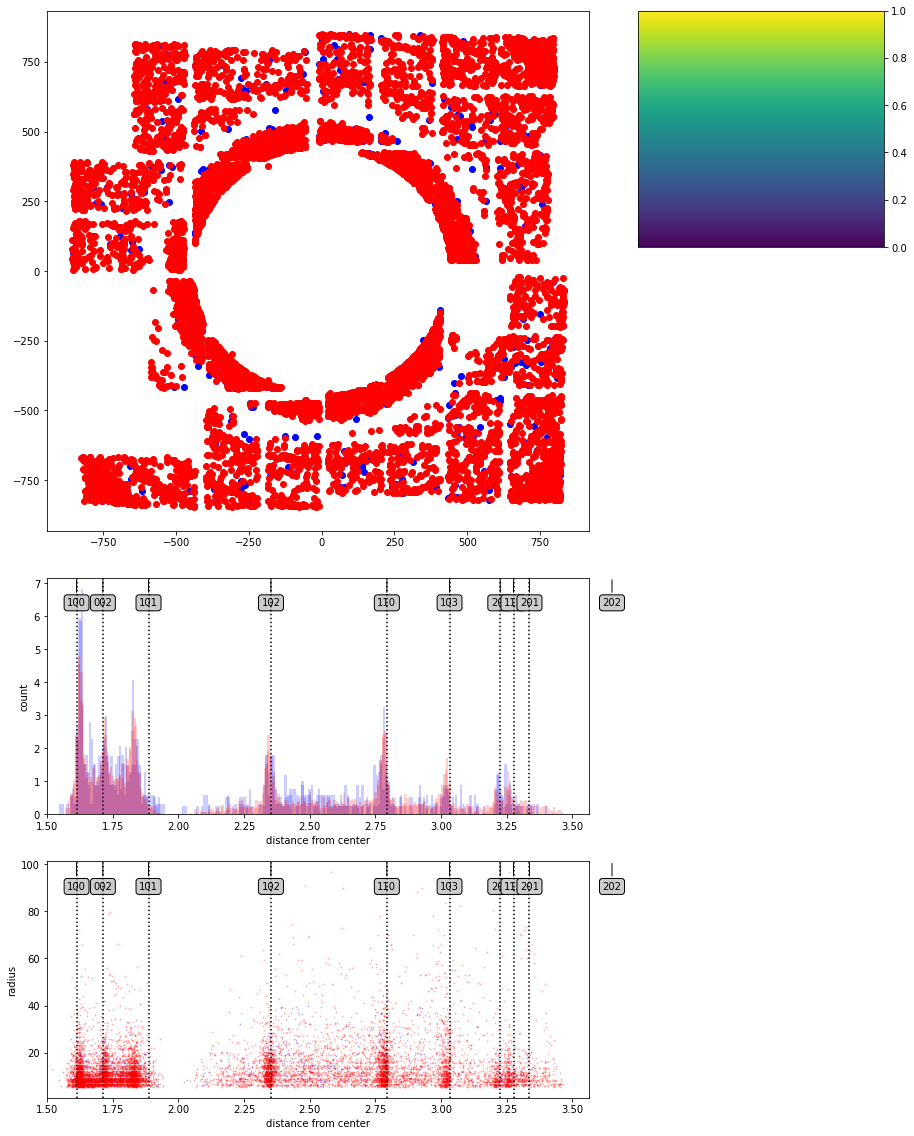

In [106]:
# Data from Jonas 20 Oct

files = ['/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0144_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0145_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0146_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0147_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0151_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0170_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0171_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0173_type1-peaks.h5']

colors = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red']

files = ['/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0144_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0145_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0171_type1-peaks.h5',
         '/Volumes/LaCie Drive/SLAC/Ice_shapes/peak_lists/r0173_type1-peaks.h5']

colors = ['blue', 'blue', 'red', 'red']

#files= ['/Users/olofjonsson/Downloads/r0144_type1-peaks.h5']


plt.close('all')
axd = plt.figure(figsize=[15, 20]).subplot_mosaic([["hits", "hits", "colorbar"], [
    "hits", "hits", "."], ["distance", "distance", "."], ["radius", "radius", "."]])


# identify_axes(axd)

ax = axd["hits"]

distance_to_center_ax = axd["distance"]


x_size = 1760
y_size = 1760
center_of_detector_pixels = [np.divide(x_size, 2), np.divide(y_size, 2)]


for file_index, file in enumerate(files):

    print(file)

    f = h5py.File(file, 'r')

    distances_to_center_pixels = []
    radii = []

    list_of_shots = [x for x in f['shots'].keys()]

    for shot_index, shot in enumerate(list_of_shots):

        if f['shots'][shot]['numberOfPeaks'][()] > 0:

            peaks = [[x-center_of_detector_pixels[0], y-center_of_detector_pixels[1]]
                     for x, y in f['shots'][shot]['peakCenterOfMassInPixels']]
            radii_this_shot = f['shots'][shot]['peakRadiiInPixels']
            for peak_index, peak in enumerate(peaks):

                peaks = ax.scatter(peak[0], peak[1], c=colors[file_index])

                distance_to_center = np.sqrt(peak[0]**2+peak[1]**2)
                distances_to_center_pixels.append(distance_to_center)
                radii.append(radii_this_shot[peak_index])

    distances_to_center = distances_to_center_pixels
    _ = distance_to_center_ax.hist(px_to_q(
        f, distances_to_center), bins=200, alpha=0.2, color=colors[file_index], density=True)
    axd["radius"].scatter(px_to_q(f, distances_to_center),
                          radii, alpha=0.2, c=colors[file_index], s=1)

    f.close()


distance_to_center_ax.set_xlabel("distance from center")
distance_to_center_ax.set_ylabel("count")
axd["radius"].set_xlabel("distance from center")
axd["radius"].set_ylabel("radius")
axd["radius"].set_xlim(left=1.5)
add_hkl_to_ax(axd["radius"], add_labels=True)


distance_to_center_ax.set_xlim(left=1.5)
plt.colorbar(peaks, cax=axd["colorbar"])

add_hkl_to_ax(distance_to_center_ax, add_labels=True)

# list_of_shots[0].value()

# center_of_mass=f['shots']['LCLS_2011_Feb28_r0144_162942_d41_cspad-angavg.h5']['peakCenterOfMassInPixels']
# peakRadiiInPixels=f['shots']['LCLS_2011_Feb28_r0144_162942_d41_cspad-angavg.h5']['peakCenterOfMassInPixels']


# plt.scatter(center_of_mass[:,0],center_of_mass[:,1],s=peakRadiiInPixels[:,1])

In [ ]:
fig

In [69]:
center_of_mass = f['shots']['LCLS_2011_Feb28_r0144_163022_45c0_cspad-angavg.h5']['peakCenterOfMassInPixels']
peakRadiiInPixels = f['shots']['LCLS_2011_Feb28_r0144_163022_45c0_cspad-angavg.h5']['peakCenterOfMassInPixels']

print(center_of_mass)

plt.scatter(center_of_mass[:, 0],
            center_of_mass[:, 1], s=peakRadiiInPixels[:, 1])

<HDF5 dataset "peakCenterOfMassInPixels": shape (0,), type "<f8">


TypeError: Argument sequence too long

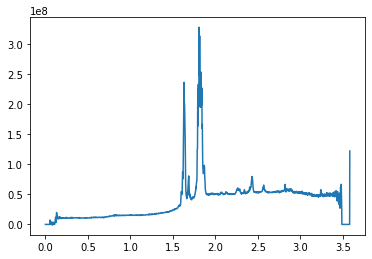

In [29]:
f = h5py.File(
    "/Users/olofjonsson/Projects/Ice_peak_shape/output_r0144/type1/LCLS_2011_Feb28_r0144_162942_d41_cspad-angavg.h5", 'r')
d = f['data']['data'][:]
plt.plot(d[0], d[1])

(1760, 1760)


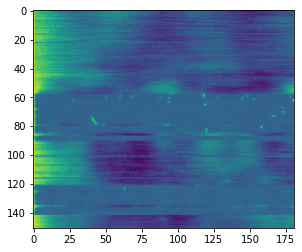

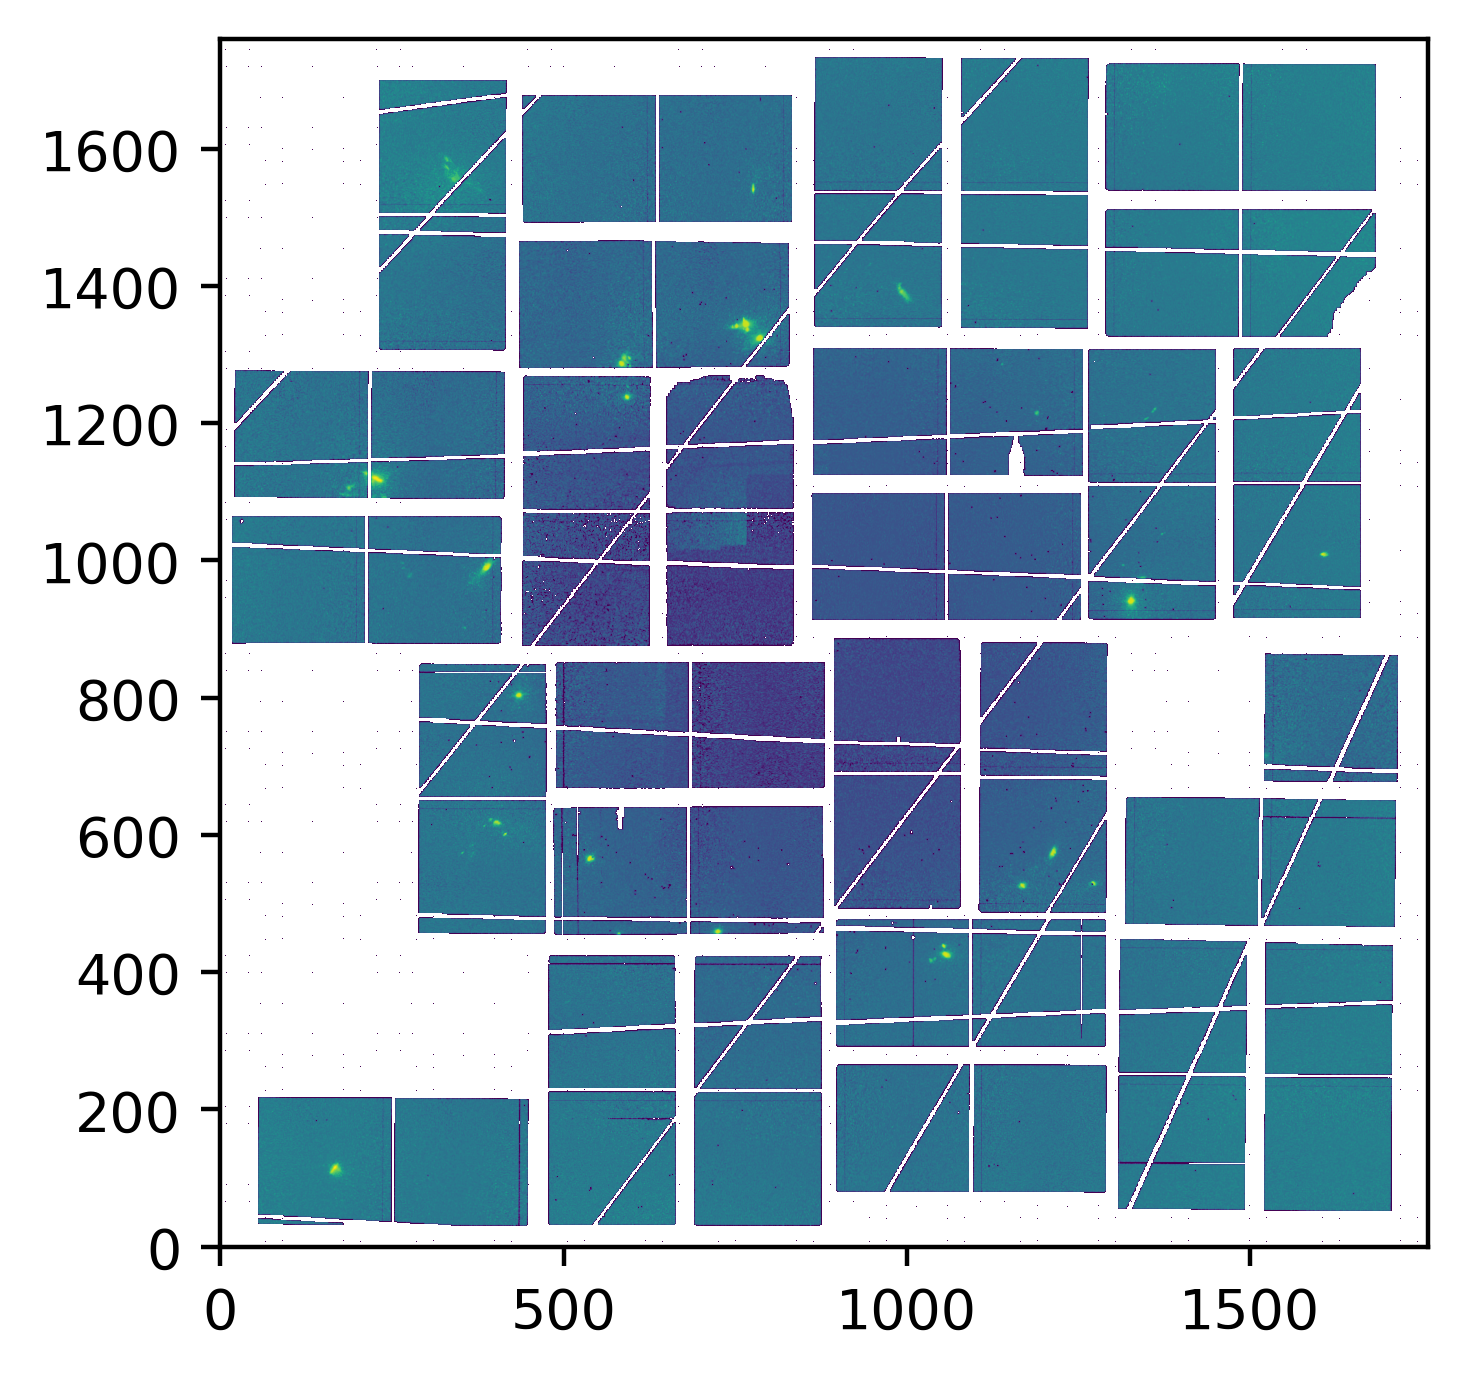

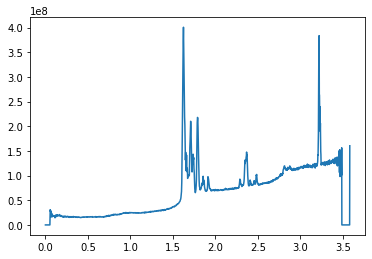

In [118]:
ang_avg = '/Users/olofjonsson/Projects/Ice_peak_shape/output_r0144/type1/LCLS_2011_Feb28_r0144_163559_1fa4_cspad-angavg.h5'
xaca = '/Users/olofjonsson/Projects/Ice_peak_shape/output_r0144/type1/LCLS_2011_Feb28_r0144_163559_1fa4_cspad-xaca.h5'
cspad = '/Users/olofjonsson/Projects/Ice_peak_shape/output_r0144/type1/LCLS_2011_Feb28_r0144_163559_1fa4_cspad.h5'

plt.figure()
f = h5py.File(xaca, 'r')
d_xaca = f['data']['data']
plt.imshow(d_xaca)

plt.figure(dpi=400)
f = h5py.File(cspad, 'r')
d_cspad = f['data']['data']
plt.imshow(d_cspad, norm=colors.LogNorm(vmin=1), origin='lower')

plt.figure()
f = h5py.File(ang_avg, 'r')
d = f['data']['data'][:]
plt.plot(d[0], d[1])

print(np.shape(d_cspad))
#f = h5py.File(xaca, 'r')
# d_xaca=f['data']['data']
# plt.imshow(d_xaca)

In [44]:
d_cspad

AttributeError: 'Dataset' object has no attribute 'max'

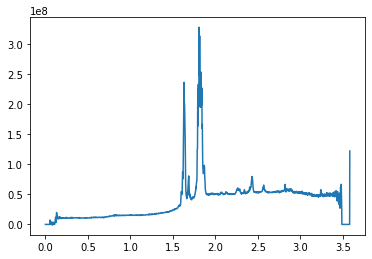